In [1]:
import pandas as pd
import shapely
from shapely import LineString, Point

import gtfs_archive
import pyproj


In [2]:
MPH_CONVERT = 2.23694

In [64]:
archive = gtfs_archive.get_gtfs_archive(20231015)
shapes = pd.read_csv(archive/"shapes.txt")
stops = pd.read_csv(archive/"stops.txt")
geod = pyproj.Geod(ellps="WGS84") # this is the model of the earth we use for distances.

Archive for 20231015 already exists: 20231011


In [65]:
shapes.iloc[0]

shape_id                  010125
shape_pt_lat           42.329848
shape_pt_lon          -71.083876
shape_pt_sequence          10001
shape_dist_traveled          NaN
Name: 0, dtype: object

# Below is a sample of how to find the distance for a single shape

In [66]:
# This is the first one in the shape file. It corresponds to bus route 1 northbound
shape010111 = shapes.loc[shapes.shape_id == "010125"].sort_values(by="shape_pt_sequence")
shape010111

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,010125,42.329848,-71.083876,10001,NaN
1,010125,42.329788,-71.083268,10002,NaN
2,010125,42.330089,-71.083198,10003,NaN
3,010125,42.330296,-71.083161,10004,NaN
4,010125,42.330493,-71.083112,10005,NaN
...,...,...,...,...,...
180,010125,42.372684,-71.116414,230005,NaN
181,010125,42.372766,-71.116680,230006,NaN
182,010125,42.372888,-71.117129,230007,NaN
183,010125,42.372964,-71.117384,230008,NaN


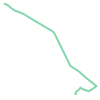

In [67]:
# note: shapely expects x,y coordinates so we have to give the points in lon, lat order.
linestring = shapely.LineString(shape010111[["shape_pt_lon","shape_pt_lat"]].to_numpy())
linestring

In [68]:
geod.geometry_length(linestring) # in meters -- This checks out with a map.

7122.42238491197

# Now let's try to calculate for all the shapes?

In [69]:
dists = {}
linestrings = {}
for name, group in shapes.groupby("shape_id"):
    pts = group[["shape_pt_lon", "shape_pt_lat"]].to_numpy()
    ls = shapely.LineString(pts)
    dists[name] = geod.geometry_length(ls)
    linestrings[name] = ls

In [70]:
distances = pd.Series(dists).rename(index="distance_m")
distances.to_csv("shape_distances.txt")

In [71]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]


In [72]:
def inner_piece(line, p1, p2):
    l2 = cut(line, line.project(p2))[0]
    l1 = cut(l2, line.project(p1))[-1]
    return l1

# Now we load all the trip/times data and group by route?

In [73]:
all_data = pd.read_csv("./data/in-data/2023/MBTA-Bus-Arrival-Departure-Times_2023-10.csv", parse_dates=["actual"])

In [74]:
# subset the data
data = all_data.loc[(all_data.route_id == "01") & (all_data.direction_id == "Outbound")]

In [75]:
def get_timepoints(data):
    all_timepoints = data[["time_point_id", "time_point_order"]].value_counts().to_frame("counts")
    filtered_timepoints = all_timepoints.loc[all_timepoints["counts"] > 100].groupby("time_point_id").idxmax()["counts"].tolist()
    timepoints = pd.DataFrame(filtered_timepoints, columns=["time_point_id", "time_point_order"]).sort_values(by="time_point_order").reset_index(drop=True)
    # chks = get_checkpoints()
    # timepoints["name"] = timepoints["time_point_id"].map(chks)
    return timepoints

In [76]:
def get_timepoints2(df):
    popular = df.groupby('half_trip_id')[['time_point_id', 'stop_id']].agg(['first','last']).value_counts().reset_index().iloc[0]
    return popular

In [77]:
data.groupby("half_trip_id")[['time_point_id','stop_id']].agg(['first', 'last']).value_counts()
#popular

(time_point_id, first)  (time_point_id, last)  (stop_id, first)  (stop_id, last)
nubn                    hhgat                  64                110                2947
                        Melwa                  64                2                     1
Name: count, dtype: int64

In [78]:
get_timepoints(data)

,time_point_id,time_point_order
0,nubn,1
1,Melwa,2
2,Wasma,3
3,masta,4
4,hynes,5
5,mit,6
6,cntsq,7
7,maput,8
8,hhgat,9


In [79]:
get_timepoints(data).iloc[[0,-1]].time_point_id

0     nubn
8    hhgat
Name: time_point_id, dtype: object

In [80]:
ends = get_timepoints(data).iloc[[0,-1]].time_point_id
trip_durations = data.loc[data.time_point_id.isin(ends)].groupby(["half_trip_id"]).agg({"actual": lambda x: x.max() - x.min()})
trip_durations = trip_durations.loc[trip_durations.actual > pd.Timedelta(0)]

In [81]:
geod.geometry_length(linestring) * len(trip_durations) / trip_durations.actual.sum().total_seconds()

3.2204342084520285

In [265]:
all_rps = pd.read_csv("./data/gtfs_archives/20231011/route_patterns.txt")
all_rps = all_rps.loc[all_rps.route_pattern_typicality == 1]
def get_rep_trip_id(route_id, dir_id):
    route_id = route_id.lstrip("0")
    if dir_id == "Outbound":
        dir = 0
    elif dir_id == "Inbound":
        dir = 1
    else:
        print("invalid direction")
        return None
    sel = all_rps.loc[(all_rps.route_id == route_id) & (all_rps.direction_id == dir)]
    if route_id == '4a':
        sel = all_rps.loc[all_rps.route_pattern_id == f'4-3-{dir}']
    elif route_id == '4p':
        sel = all_rps.loc[all_rps.route_pattern_id == f'4-4-{dir}']
    if route_id == '29':
        # this assumes they don't go to Franklin Field. Most trips wil appear slower than reality.
        sel = all_rps.loc[all_rps.route_pattern_id == f'29-5-{dir}']
    if len(sel) > 1:
        print(f"multiple route patterns found for {route_id}-{dir_id}")
        # return None
    if len(sel) == 0:
        print(f"no route pattern found for {route_id}-{dir_id}")
        return None
    return sel.iloc[0].representative_trip_id

In [268]:
rp4s = all_rps.loc[all_rps.route_id == '708']
rp4s

,route_pattern_id,route_id,direction_id,route_pattern_name,route_pattern_time_desc,route_pattern_typicality,route_pattern_sort_order,representative_trip_id,canonical_route_pattern
217,708-1-0,708,0,Andrew Station - Ave Louis Pasteur,Weekdays only,1,400300000,58402506,0
218,708-_-0,708,0,Andrew Station - Brookline Ave,Weekdays only,1,400300020,58402466,0
219,708-_-1,708,1,Brookline Ave - Andrew Station,Weekdays only,1,400301000,58402808,0
220,708-1-1,708,1,Ave Louis Pasteur - Andrew Station,Weekdays only,1,400301020,58404022,0


In [270]:
for f in rp4s.representative_trip_id:
    print(f, geod.geometry_length(linestrings[get_shape_id(f)]))

58402506 6383.267347954332
58402466 6255.35907397699
58402808 6670.341838678673
58404022 6908.535200347104


In [133]:
all_rps.route_id.value_counts().to_csv("gtfs_trip_ids.csv")

In [83]:
all_trips = pd.read_csv("./data/gtfs_archives/20230914/trips.txt")
def get_shape_id(rep_trip_id):
    trip = all_trips.loc[all_trips.trip_id == rep_trip_id]
    return trip.iloc[0].shape_id

In [84]:
import numpy as np
np.seterr(invalid='ignore')
def get_speed(subset):
    return subset.distance.sum() / subset.actual.sum().total_seconds() * MPH_CONVERT

In [260]:
def get_gtfs_route_id(rid):
    if rid == 'SL1':
        return '741'
    if rid == 'SL2':
        return '742'
    if rid == "SL4":
        return '751'
    if rid == 'SL5':
        return '749'
    if rid == 'CT2':
        return '747'
    if rid == 'CT3':
        return '708'
    return rid

In [266]:
pokey = []
for route_id in ['29']:#np.append(all_data.route_id.unique(), ['04a', '04p']):
    if route_id in ['191','194','192','193']:
        continue
    perroute = []
    for direction_id in ["Outbound", "Inbound"]:
        rep_trip_id = get_rep_trip_id(get_gtfs_route_id(route_id), direction_id)
        if not rep_trip_id:
            continue
        shape_id = get_shape_id(rep_trip_id)
        data = all_data.loc[(all_data.route_id == route_id) & (all_data.direction_id == direction_id)]
        if route_id == '04a':
            data = all_data.loc[(all_data.route_id == '04') & (all_data.direction_id == direction_id) & (all_data.actual.dt.hour < 12)]
        elif route_id == '04p':
            data = all_data.loc[(all_data.route_id == '04') & (all_data.direction_id == direction_id) & (all_data.actual.dt.hour >= 12)]
        # popular = get_timepoints2(data)
        index = 0
        if route_id == '15' and direction_id == "Outbound":
            index = 1
        popular = data.groupby('half_trip_id')[['time_point_id', 'stop_id']].agg(['first','last']).value_counts().reset_index().iloc[index]
        # print(popular)
        # ends = tpts.iloc[[0,-1]].time_point_id
        ends = [popular[('time_point_id', 'first')], popular[('time_point_id','last')]]
        trip_durations = data.loc[data.time_point_id.isin(ends)].groupby(["half_trip_id"]).agg(
            actual=pd.NamedAgg(column="actual", aggfunc=lambda x: x.max() - x.min()),
            start_time=pd.NamedAgg(column="actual", aggfunc="min"),
            end_time=pd.NamedAgg(column="actual", aggfunc="max"),
            service_date=pd.NamedAgg(column="service_date", aggfunc="first")
        )
        trip_durations = trip_durations.loc[trip_durations.actual > pd.Timedelta(0)]
        trip_durations['service_date'] = pd.to_datetime(trip_durations.service_date)
        ls = linestrings[shape_id]
        stop1 = stops.loc[stops.stop_id == str(popular[('stop_id','first')])]
        stop2 = stops.loc[stops.stop_id == str(popular[('stop_id','last')])]
        begin = shapely.Point(stop1.stop_lon, stop1.stop_lat)
        end = shapely.Point(stop2.stop_lon, stop2.stop_lat)
        segment = inner_piece(ls, begin, end)
        if route_id == '120' and direction_id == "Outbound":
            segment = ls
        dist = geod.geometry_length(segment)
        # print(dist)
        trip_durations['distance'] = dist
        # trip_durations['peak'] = trip_durations.start_time.dt.hour.isin([6,7,8,15,16,17]) & trip_durations.service_date.dt.day_of_week < 5
        trip_durations['day'] = trip_durations.start_time.dt.hour.isin(range(7,19)) & (trip_durations.service_date.dt.day_of_week < 5)
        # speed = dist * len(trip_durations) / trip_durations.actual.sum().total_seconds()
        day_subset = trip_durations.loc[trip_durations.day]
        day_speed = get_speed(day_subset)
        day_count = len(day_subset)
        other_subset = trip_durations.loc[~trip_durations.day]
        other_speed = get_speed(other_subset)
        other_count = len(other_subset)
        total_speed = get_speed(trip_durations)
        total_count = len(trip_durations)
        # TODO: add total stops/mile
        res = [route_id, direction_id, day_speed, day_count, other_speed, other_count, total_speed, total_count, dist, ends[0], ends[1]]
        perroute.append(res)
        # break
    pokey.extend(perroute)

        

In [267]:
pokey

[['29',
  'Outbound',
  7.991024854625424,
  259,
  12.573179871495078,
  183,
  9.411032730545765,
  442,
  7426.732747637108,
  'jasst',
  'matpn'],
 ['29',
  'Inbound',
  7.8169579406280825,
  263,
  10.634908650131894,
  213,
  8.86848846658025,
  476,
  7201.128069078987,
  'matpn',
  'jasst']]

In [115]:
# cool 1 inbound breakdown by hour of day. 7a-7p feels very justified for this route.
trip_durations.groupby(trip_durations.start_time.dt.hour).apply(lambda x: get_speed(x))

start_time
4      9.803190
5     10.265576
6      7.028748
7      6.334065
8      6.033933
9      5.937832
10     6.398492
11     6.576673
12     6.317935
13     6.475775
14     6.233021
15     5.588175
16     5.843233
17     5.842095
18     5.262182
19     7.008414
dtype: float64

In [204]:
pd.DataFrame(pokey).sort_values(by=2).to_csv("pokey_prelim_oct.csv")

In [257]:
p2 = pokey.copy()

In [258]:
fdf = pd.DataFrame(p2)
fdf.columns = ("route_id", "direction_id", "day_speed", "day_trip_count", "offhour_speed", "offhour_trip_count", "total_speed", "total_trip_count", "distance_m", "from_timepoint", "to_timepoint")
fdf['offhour_speed_minus_day_speed'] = fdf.offhour_speed - fdf.day_speed
fdf.sort_values(by='day_speed').head(20)
#fdf.to_csv("pokey_data_breakdown_oct.csv", index=False)

,route_id,direction_id,day_speed,day_trip_count,offhour_speed,offhour_trip_count,total_speed,total_trip_count,distance_m,from_timepoint,to_timepoint,offhour_speed_minus_day_speed
197,04,Outbound,3.940606,182,6.060557,36,4.182187,218,3049.174367,drdck,north,2.119951
290,CT3,Inbound,5.312584,240,7.984155,45,5.608920,285,6023.909928,louis,andrw,2.671572
293,04p,Outbound,5.359765,97,NaN,0,5.359765,97,4449.295515,drdck,north,NaN
132,55,Inbound,5.879175,178,6.353190,51,5.978516,229,2657.856182,jqnsb,stjim,0.474015
294,04p,Inbound,5.972483,87,6.586148,1,5.978813,88,5031.751979,north,drdck,0.613665
286,92,Inbound,5.995328,212,6.711964,86,6.185934,298,4211.496758,sull,milk,0.716636
284,85,Inbound,6.118242,205,8.962143,70,6.655858,275,2981.012758,bwsvl,kndl,2.843901
198,04,Inbound,6.197039,183,7.782040,22,6.335519,205,4565.077885,north,drdck,1.585002
0,01,Outbound,6.374536,1117,8.017385,1428,7.202666,2545,7121.184563,nubn,hhgat,1.642849
283,85,Outbound,6.443213,188,9.877170,84,7.218215,272,2829.641082,kndl,bwsvl,3.433957


In [207]:
fdf

,route_id,direction_id,day_speed,day_trip_count,offhour_speed,offhour_trip_count,total_speed,total_trip_count,distance_m,from_timepoint,to_timepoint,offhour_speed_minus_day_speed
0,01,Outbound,6.374536,1117,8.017385,1428,7.202666,2545,7121.184563,nubn,hhgat,1.642849
1,01,Inbound,6.711094,1162,8.733125,1407,7.685707,2569,7445.930107,hhgat,nubn,2.022031
2,08,Outbound,7.497061,353,10.371885,456,8.885216,809,13626.351826,kenbs,umass,2.874823
3,08,Inbound,7.796865,470,10.571383,505,9.023507,975,12827.614896,umass,kenbs,2.774517
4,09,Outbound,7.959338,1139,9.704404,813,8.603715,1952,6348.534462,copst,ctypt,1.745065
...,...,...,...,...,...,...,...,...,...,...,...,...
260,CT2,Inbound,7.757582,307,9.246504,57,7.958253,364,10547.224978,sull,rugg,1.488922
261,04a,Outbound,7.328052,85,10.333816,36,8.022292,121,5199.127255,drdck,north,3.005764
262,04a,Inbound,8.090960,96,8.966590,21,8.235307,117,5184.220455,north,drdck,0.875630
263,04p,Outbound,5.359765,97,NaN,0,5.359765,97,4449.295515,drdck,north,NaN


In [261]:
pivoted = fdf.pivot(columns="direction_id", index="route_id")
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
sum = pivoted.day_trip_count_Outbound + pivoted.day_trip_count_Inbound
mean = (pivoted.day_speed_Inbound * pivoted.day_trip_count_Inbound + pivoted.day_speed_Outbound * pivoted.day_trip_count_Outbound) / sum
# mean = (pivoted.day_speed_Inbound + pivoted.day_speed_Outbound) / 2
pivoted['trip_count'] = sum
pivoted['mean_speed_mph'] = mean
# pivoted.to_csv("pokey_data_breakdown_pivoted.csv")
top = pivoted[['trip_count','mean_speed_mph']].sort_values(by='mean_speed_mph')
#top.to_csv("pokey_day_top_oct.csv")
top[['mean_speed_mph','trip_count']].head(50)


,mean_speed_mph,trip_count
route_id,,
04,5.071913,365.0
04p,5.649474,184.0
85,6.273699,393.0
55,6.298983,348.0
01,6.546138,2279.0
15,6.647654,1278.0
91,6.678734,775.0
SL4,6.744154,1975.0
19,6.798191,584.0


In [214]:
(181*7.732688 + 184*5.649474) / (181+184)

6.6825198465753415

In [345]:
fdf['diff'] = fdf.offhour_speed - fdf.day_speed

In [346]:
fdf.sort_values(by='diff', ascending=True).head(20)

,route_id,direction_id,day_speed,day_trip_count,offhour_speed,offhour_trip_count,total_speed,total_trip_count,distance_m,from_timepoint,to_timepoint,offhour_speed_minus_day_speed,diff
132,428,Inbound,13.918635,9,12.533443,20,12.932885,29,22312.032264,oakvl,hayms,-1.385191,-1.385191
62,202,Outbound,10.682423,231,10.123038,8,10.662701,239,4028.733258,fldcr,keyst,-0.559385,-0.559385
74,217,Outbound,13.692529,58,13.176918,18,13.566797,76,15087.134711,ashmt,qnctr,-0.515611,-0.515611
171,55,Outbound,6.234577,189,6.037085,63,6.184002,252,2939.565236,stjim,jqnsb,-0.197492,-0.197492
189,62,Outbound,17.813706,307,17.730752,175,17.783499,482,20150.528837,alewf,vahsp,-0.082954,-0.082954
245,97,Outbound,10.355388,308,10.395559,85,10.364050,393,7827.290511,welst,malst,0.040171,0.040171
128,424,Inbound,13.972636,37,14.225612,43,14.107482,80,13299.590587,essex,wondw,0.252976,0.252976
44,131,Inbound,13.238728,148,13.531171,15,13.265110,163,11327.694073,mrose,malst,0.292443,0.292443
246,97,Inbound,10.568859,300,10.900851,110,10.655929,410,8096.536643,malst,welst,0.331992,0.331992
61,201,Inbound,10.876699,418,11.258284,507,11.082585,925,3299.613444,adgal,fldcr,0.381584,0.381584


In [278]:
fdf.day_speed * fdf.day_trip_count

0       7604.262160
1       8555.336317
2      10707.708987
3       9442.220844
4       3307.258193
           ...     
244     3876.265462
245     3189.459515
246     3170.657794
247     3524.836308
248     4035.331438
Length: 249, dtype: float64

In [156]:
get_shape_id(get_rep_trip_id("171", "Outbound"))

'1710019'

In [157]:
data = all_data.loc[(all_data.route_id == "171") & (all_data.direction_id == "Outbound")]

In [34]:
pokey = []

def analyze(route_id, dir):
    print(route_id)
    for direction_id in [["Outbound", "Inbound"][dir]]:
        print(direction_id)
        rep_trip_id = get_rep_trip_id(route_id, direction_id)
        if not rep_trip_id:
            continue
        shape_id = get_shape_id(rep_trip_id)
        data = all_data.loc[(all_data.route_id == route_id) & (all_data.direction_id == direction_id)]
        tpts = get_timepoints(data)
        if tpts.empty:
            continue
        ends = tpts.iloc[[0,-1]].time_point_id
        trip_durations = data.loc[data.time_point_id.isin(ends)].groupby(["half_trip_id"]).agg({"actual": lambda x: x.max() - x.min()})
        trip_durations = trip_durations.loc[trip_durations.actual > pd.Timedelta(0)]
        speed = distances[shape_id] * len(trip_durations) / trip_durations.actual.sum().total_seconds()
        count = trip_durations.actual.count()
        print(route_id, direction_id, speed, count)
        pokey.append([route_id, direction_id, speed, count])
        

In [47]:
analyze('34',1)

34
Inbound
34 Inbound 8.383787660223717 237


In [50]:
get_rep_trip_id('34', "Inbound")

'55889533'

In [40]:
trip_durations

,actual
half_trip_id,
59644942.0,0 days 00:44:40
59644946.0,0 days 00:37:51
59644948.0,0 days 00:33:12
59644950.0,0 days 00:29:07
59644952.0,0 days 00:18:38
...,...
59957684.0,0 days 00:39:57
59957686.0,0 days 00:31:33
59957688.0,0 days 00:36:05
